In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import json

from sorbetto.core.entity import Entity
from sorbetto.performance.two_class_classification_performance import TwoClassClassificationPerformance
from sorbetto.parameterization.parameterization_default import ParameterizationDefault
from sorbetto.analysis.analysis_method_designer import AnalysisForMethodDesigner

# How to use the tile: Method Designer guide


## Method designer



The method designer wants to test and compare their newly developed method against existing ones. Their focus is on analyzing strengths and weaknesses across different evaluation perspectives, and possibly tuning hyperparameters to improve performance. They are less concerned with pure theory and more with how well their method performs compared to baselines and state-of-the-art. In short, they care about evaluating and improving their own models.

In this notebook, we show how the tile can be used for such an objective.

For more information, please refer to the  [*reference paper*](https://arxiv.org/abs/2412.04377).

### Data

In this example, the list of entities are the different deep learning models from mmsegmentation that are obtained on cityscape data.

In [2]:
# loading data


PATH_DATA = os.path.join(os.getcwd(), 'data', 'semantic_segmentation_methods.json')

MAP_DATASETS = {
    'Cityscapes': '♠',
    'ADE20K': '♥',
    'Pascal VOC 2012': '♦',
    'COCO-Stuff 164k': '♣'
}

def get_colors ( num_colors ) :
    x = np.linspace ( 0.0 , 1.0 , num_colors )
    a = np.floor ( x * x * np.sqrt ( num_colors ) )
    v = 1.0 - a / ( np.max ( a ) + 1 )
    h = x * x * ( np.max ( a ) + 1 )
    h = h - np.floor ( h )
    hsv = np.ones ( [num_colors,3] )
    hsv [:,0] = h
    hsv [:,1] = v
    hsv [:,2] = 1.0
    rgb = hsv_to_rgb( hsv )
    rgba = np.ones ( [num_colors,4] )
    rgba [:,0:3] = rgb
    return rgba

def read_json(filePath:str):
    """
    Function to read json 
    """
    
    with open(filePath, 'r') as f:
        data = json.load(f)
    return data


def read_data(filePath:str = PATH_DATA):
    data = read_json(filePath)

    processed_data = []

    colors = get_colors(len(data))

    # convert each instance into an Entity
    for i, elem in enumerate(data):
        performance = TwoClassClassificationPerformance(
            ptp=elem['proba_tp'],
            ptn=elem['proba_tn'],
            pfp=elem['proba_fp'],
            pfn=elem['proba_fn']
        )

        entity = Entity(
            performance= performance,
            name = f"{elem['model']} {MAP_DATASETS[elem['learning_set']]}",
            color= colors[i]
        )

        processed_data.append(entity)

    return processed_data

data = read_data()

## Loading the analysis

In [3]:
param = ParameterizationDefault()

analysis = AnalysisForMethodDesigner(entities=data,
                                     parameterization=param,
                                     resolution=1001)

The first step is to get the baseline and the sota tiles. These tiles respectively contain the values obtained by the best and worst entity. 

### Value Tile

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Value Tile'}, xlabel='a(I)', ylabel='b(I)'>)

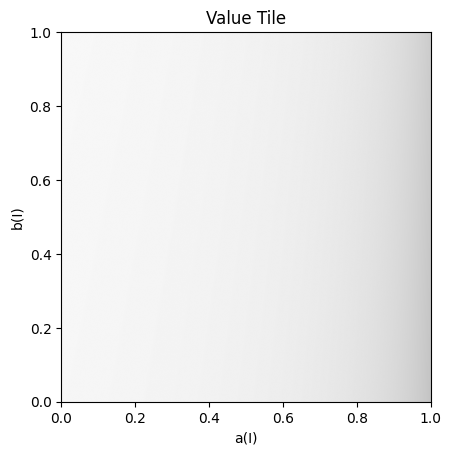

In [4]:
id_entity = 5
val_tile = analysis.getValueTile(entity=data[id_entity])
val_tile.draw()

### Baseline Value tile



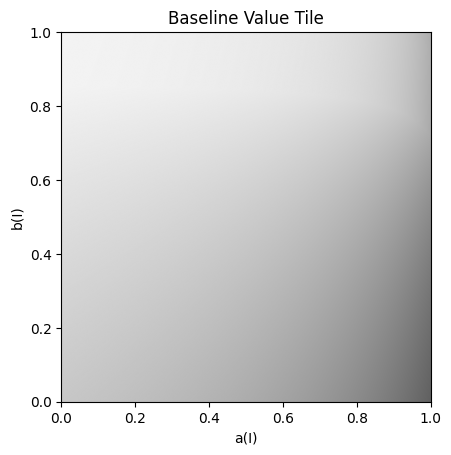

In [8]:
baseline_val_tile = analysis.getBaselineValueTile()
baseline_val_tile.draw()
plt.show()        

### SOTA Value tile

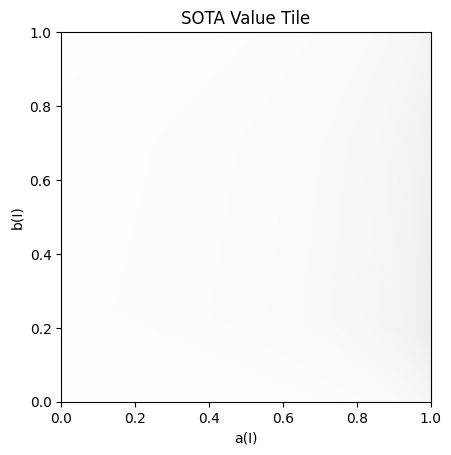

In [9]:
sota_val_tile = analysis.getSOTAValueTile()
sota_val_tile.draw()
plt.show()

### Comparing tiles

It is possible to directly observe the absolute difference between the value tile and the baseline and sota tiles.

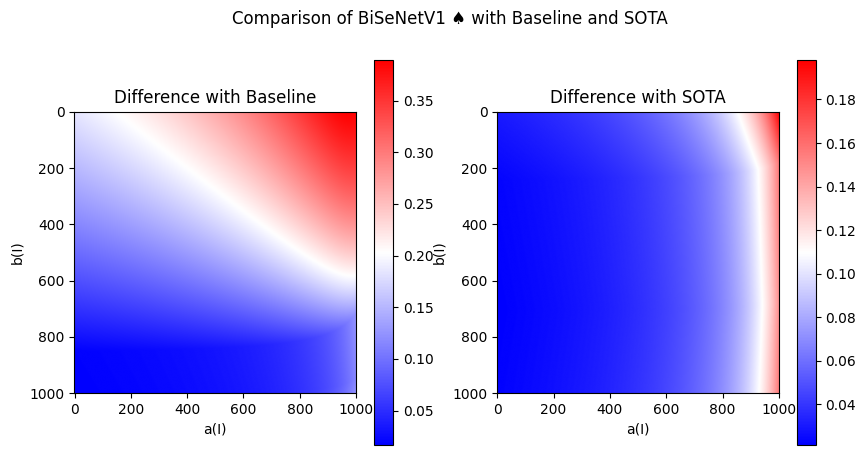

In [7]:
diff_baseline, diff_sota = analysis.compare_tiles(entity=data[id_entity])

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle(f"Comparison of {data[id_entity].name} with Baseline and SOTA")
im1 = ax[0].imshow(diff_baseline.data, cmap='bwr')
ax[0].set_title("Difference with Baseline")
ax[0].set_xlabel("a(I)")
ax[0].set_ylabel("b(I)")

fig.colorbar(im1, ax=ax[0])
im2 = ax[1].imshow(diff_sota.data, cmap='bwr')
ax[1].set_title("Difference with SOTA")
ax[1].set_xlabel("a(I)")
ax[1].set_ylabel("b(I)")

fig.colorbar(im2, ax=ax[1])
plt.show()